In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from scipy.stats import mode
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
df = pd.read_csv('/content/drive/MyDrive/University/MemoireAbdelmalek/data/all/characters.csv')
X = df[['flex_1', 'flex_2', 'flex_3', 'flex_4', 'flex_5', 'GYRx', 'GYRy', 'GYRz', 'ACCx', 'ACCy', 'ACCz']].values
labels = df.iloc[:, -1]
label_dict = {label: i for i, label in enumerate(sorted(set(labels)))}
y = np.array([label_dict[label] for label in labels])
y = to_categorical(y, num_classes=len(label_dict))

print(label_dict)

X = np.reshape(X, (X.shape[0]//150, 150, X.shape[1]))
y = np.reshape(y, (y.shape[0]//150, 150, y.shape[1]))
print(X.shape, y.shape)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
(6500, 150, 11) (6500, 150, 26)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)

(5200, 150, 11) (1300, 150, 11)


In [5]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [6]:
input_layer = Input(shape=(150, 11), name='input_layer')
lstm_layer = LSTM(units=38, return_sequences=True, name='lstm_layer')(input_layer)
output_layer = Dense(units=len(label_dict), activation='softmax', name='output_layer')(lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [7]:
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train)):
    print(f"Fold {fold+1}")
    model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[checkpoint_callback])

Fold 1
Epoch 1/50
125/130 [===========================>..] - ETA: 0s - loss: 3.3596 - accuracy: 0.0663
Epoch 1: val_accuracy improved from -inf to 0.07467, saving model to best_model.h5
130/130 [==============================] - 8s 16ms/step - loss: 3.3541 - accuracy: 0.0681 - val_loss: 3.2759 - val_accuracy: 0.0747
Epoch 2/50
124/130 [===========================>..] - ETA: 0s - loss: 3.2064 - accuracy: 0.0991
Epoch 2: val_accuracy improved from 0.07467 to 0.10971, saving model to best_model.h5
130/130 [==============================] - 2s 12ms/step - loss: 3.2076 - accuracy: 0.0971 - val_loss: 3.1499 - val_accuracy: 0.1097
Epoch 3/50
125/130 [===========================>..] - ETA: 0s - loss: 3.0843 - accuracy: 0.1316
Epoch 3: val_accuracy improved from 0.10971 to 0.14564, saving model to best_model.h5
130/130 [==============================] - 1s 11ms/step - loss: 3.0850 - accuracy: 0.1321 - val_loss: 3.0388 - val_accuracy: 0.1456
Epoch 4/50
130/130 [==============================] - 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)

(5200, 150, 11) (1300, 150, 11)


In [9]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=150, callbacks=[checkpoint_callback])

Epoch 1/150
141/147 [===========================>..] - ETA: 0s - loss: 0.2171 - accuracy: 0.9429
Epoch 1: val_accuracy did not improve from 0.92436
147/147 [==============================] - 2s 8ms/step - loss: 0.2176 - accuracy: 0.9427 - val_loss: 0.2602 - val_accuracy: 0.9243
Epoch 2/150
143/147 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9449
Epoch 2: val_accuracy did not improve from 0.92436
147/147 [==============================] - 2s 11ms/step - loss: 0.2141 - accuracy: 0.9441 - val_loss: 0.2622 - val_accuracy: 0.9240
Epoch 3/150
143/147 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.9448
Epoch 3: val_accuracy improved from 0.92436 to 0.92799, saving model to best_model.h5
147/147 [==============================] - 2s 12ms/step - loss: 0.2132 - accuracy: 0.9448 - val_loss: 0.2562 - val_accuracy: 0.9280
Epoch 4/150
141/147 [===========================>..] - ETA: 0s - loss: 0.2077 - accuracy: 0.9473
Epoch 4: val_accuracy did not

In [10]:
results = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

41/41 [==============================] - 1s 5ms/step


In [11]:
predictions = np.argmax(y_pred, axis=2)
print(predictions)
major = np.squeeze(mode(predictions)[0])
count = np.squeeze(mode(predictions)[1])
print(f"Predictions    : {major}")
print(f"Appeared times : {count}")

[[17 17 17 ... 13 13 13]
 [19 19 19 ...  3  3  3]
 [ 8  8  8 ...  8  8  8]
 ...
 [ 6  6  6 ...  6  6  6]
 [25 25 25 ... 25 25 25]
 [ 3  3  3 ...  3  3  3]]
Predictions    : [20 20 20  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  6  8  8  8  8  8  8  8  8
  8  8  8  8  8  2  8  8  2  8  8  8  8  2  8  8  2  8  8  8  8  8  8  2
  6  2  2  2  6  6  6  2  2  2  2  6  2  2  8  8  8  8  8  8  2  8  8  2
  8  8  8  8  6  8  2  2  2  2  6  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2]
Appeared times : [101  79  69  68  68  68  66  67  68  67  65  63  64  66  68  66  67  65
  64  66  66  65  68  67  68  67  66  68  67  68  67  67  65  64  67  66
  64  64  63  64  65  64  64  63  62  63  64  63  63  63  63  63  63  63
  63  63  63  63  61  60  61  61  61  59  60  61  61  61  60  61  61  61
  61  61  61  61  61  60  60  60  61  61  60  60  60  60  60

<ipython-input-11-f892e764b43a>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  major = np.squeeze(mode(predictions)[0])
<ipython-input-11-f892e764b43a>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  count = np.squeeze(mode(predictions)[1])


In [12]:
def get_key(dictionary, val):
    for key, value in dictionary.items():
        if val == value:
            return key

predictions_list = []
for word in major:
    predictions_list.append(get_key(label_dict, word))
print(predictions_list)

['u', 'u', 'u', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'g', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'c', 'i', 'i', 'c', 'i', 'i', 'i', 'i', 'c', 'i', 'i', 'c', 'i', 'i', 'i', 'i', 'i', 'i', 'c', 'g', 'c', 'c', 'c', 'g', 'g', 'g', 'c', 'c', 'c', 'c', 'g', 'c', 'c', 'i', 'i', 'i', 'i', 'i', 'i', 'c', 'i', 'i', 'c', 'i', 'i', 'i', 'i', 'g', 'i', 'c', 'c', 'c', 'c', 'g', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


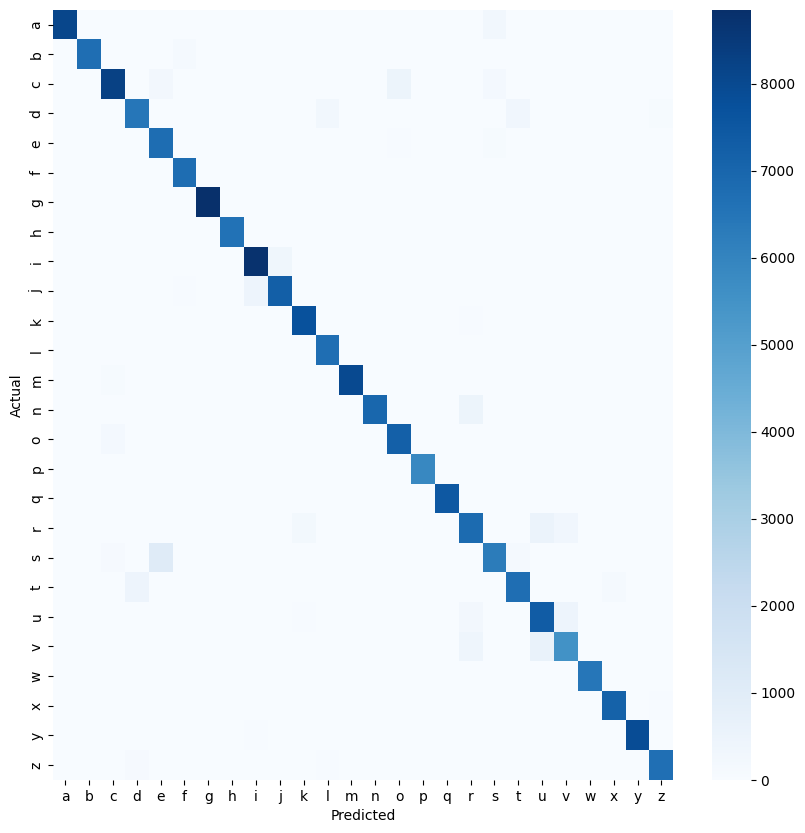

Accuracy: 95.03%


In [13]:
cm = confusion_matrix(y_test.argmax(axis=2).flatten(), y_pred.argmax(axis=2).flatten())
plt.subplots(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy: {accuracy*100:.2f}%")

In [14]:
print(classification_report(y_test.argmax(axis=2).flatten(), y_pred.argmax(axis=2).flatten()))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8400
           1       1.00      0.98      0.99      6900
           2       0.95      0.89      0.92      9300
           3       0.91      0.89      0.90      7200
           4       0.83      0.98      0.90      6900
           5       0.97      1.00      0.99      6750
           6       1.00      1.00      1.00      8850
           7       1.00      1.00      1.00      6600
           8       0.94      0.96      0.95      9150
           9       0.95      0.93      0.94      7800
          10       0.96      0.99      0.97      7800
          11       0.95      1.00      0.97      6750
          12       1.00      0.99      0.99      8100
          13       0.99      0.93      0.96      7500
          14       0.93      0.96      0.94      7500
          15       1.00      1.00      1.00      5850
          16       1.00      1.00      1.00      7500
          17       0.85    

In [15]:
# model.save('/content/drive/MyDrive/University/MemoireAbdelmalek/models/characters.h5')
model.save('characters.h5')

In [ ]:
run_model = tf.function(lambda x: model(x))
BATCH_SIZE = 1
INPUT_SIZE = 150
STEPS = 11
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, INPUT_SIZE, STEPS], model.inputs[0].dtype))

MODEL_DIR = "./"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.allow_custom_ops = False
tflite_model = converter.convert()

In [ ]:
# with open('/content/drive/MyDrive/University/MemoireAbdelmalek/models/characters.tflite', 'wb') as f:
#     f.write(tflite_model)
with open('characters.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!xxd -i characters.tflite > characters.cc
# !xxd -i characters.tflite drive/MyDrive/University/MemoireAbdelmalek/models/characters.cc
!ls drive/MyDrive/University/MemoireAbdelmalek/models